In [11]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

### 1. Basic logistic regression


So we need to read the data, name columns and take mean over Videos for each Subject

In [12]:
data=pd.read_csv("./data/EEG data.csv", header=None)

names={0: "Subject ID", 1: "Video ID",2:"Attention",3:"Mediation",4:"Raw",5: "Delta",6:" Theta",7: "Alpha 1",8: "Alpha 2",9: "Beta 1", 10: "Beta 2" ,11: "Gamma 1", 12: "Gamma 2",13: "predefined label", 14: "user-defined label"}
data=data.rename(columns=names)
data=data.groupby(["Subject ID", "Video ID"]).mean()

features =["Delta"," Theta", "Alpha 1", "Alpha 2", "Beta 1", "Beta 2" , "Gamma 1", "Gamma 2"]
X=data[features].values

y=data["user-defined label"].values

### 1.1 Class imbalance

In [13]:
print("Proportion of class 1 for ReportedConfusion {0}".format(data["user-defined label"].sum()/data["user-defined label"].count()))
print("Proportion of class 1 for ReportedConfusion {0}".format(data["predefined label"].sum()/data["predefined label"].count()))

Proportion of class 1 for ReportedConfusion 0.51
Proportion of class 1 for ReportedConfusion 0.5


So the classes are almost balanced. It is important to this about class imbalance once more during CV, because we want our train and test data to be balanced. 

### 1.2 Unregularised LR 

####  Normalization of our features. 

As many of you I first also got stange results for L2. For example, the results for L2 and L1 regression  with big $C$ were different. That is quite bad, as we expect them to be the same model when $C \rightarrow \infty$. In this cases you need to check maybe someone alredy had the same problem.   

I have found that the problem in with unnormilised features. 

You can't just normalize the whole data set because then you use part of the data, that is test data during training of your model. To avoid this we need to find the mean and std for normalization using only train data and then apply the same transformation to the test data. 

Look [here](#normalization) to see the detailed implementation of normalization. 

P.S. As it was not said in the task to normalized your data it is not effecting your grades. Just try to remember importance of normalization for your own projects.

In [14]:
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import Pipeline
# create pipeline with scaling of the features 
def create_model(clf):
    estimators = []
    estimators.append(('standardize',StandardScaler()))
    estimators.append(('clf', clf))
    model = Pipeline(estimators)
    return model 

For Unregularised LR in sklearn you just you quite large $C$ (so quite small penalty $\frac{1}{C}$). As you can see it is not often used. 

In [15]:
clf = LogisticRegression(penalty = "l2",C=1000000,fit_intercept=True)
model1 = create_model(clf)

In [17]:
model1.fit(X,y) # add normalization 
accuracy = (model1.predict(X)==y).sum()/y.shape[0] #strange results without normalization - why does our predictions are the same with different C?

print ("Accuracy for unregularised LR: {0:0.3}".format(accuracy))

Accuracy for unregularised LR: 0.67


As you already know how to apply ````cross_val_score```` with ````cv=int````, I want to show what exectly it does. 
First of all, it uses ````StratifiedKFold```` that is different from ```KFold```. Stratification seeks to ensure that each fold is representative of all strata of the data. Generally this is done in a supervised way for classification and aims to ensure each class is (approximately) equally represented across each test fold (which are of course combined in a complementary way to form training folds)

Also, as our data set has intrinsic structure (the first ten from the same Subject 1 and so on), it is important to shuffle the whole data before spliting. As different random seeds will give you different results, it is also important to look several different splits and average the results. 

In [19]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

In [21]:
def calculate_score(clf, X, y):
    cv = StratifiedKFold(10,shuffle=True)
    std=[]
    mean=[]
    for i in range(50):
        scores = cross_val_score(clf, X, y, cv=cv)
        std.append(scores.std())
        mean.append(scores.mean())
    print("Mean 10-fold cross-validation accuracy {0:0.4}, Standard deviation of the estimated accuracy {1:0.3}"
          .format(np.mean(mean), np.mean(std)))

calculate_score(model1, X, y)

Mean 10-fold cross-validation accuracy 0.6057, Standard deviation of the estimated accuracy 0.143


In [22]:
features_reduced = ["Delta", "Beta 1"]
X_reduced = data[features_reduced].values
calculate_score(model1, X_reduced, y)

Mean 10-fold cross-validation accuracy 0.6705, Standard deviation of the estimated accuracy 0.135


### 2 . Linear and quadratic discriminant analysis

In [23]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

clf = LinearDiscriminantAnalysis()
calculate_score(create_model(clf), X, y)

Mean 10-fold cross-validation accuracy 0.6267, Standard deviation of the estimated accuracy 0.14


In [25]:
clf = QuadraticDiscriminantAnalysis()
calculate_score(create_model(clf), X, y)

Mean 10-fold cross-validation accuracy 0.617, Standard deviation of the estimated accuracy 0.138


Linear DA is comparable to Quadratic, where as LR is a bit worse and LR are quite similar. I whould use LDA because it is simpler, that is good when we have such small datasets

### 3. Penalized logistic regression 

#### L1 regularization 

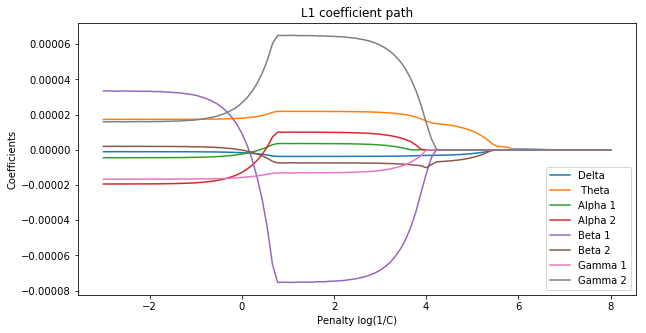

In [26]:
Cs = np.logspace(-8, 3, 100)
penalties = (1/Cs)
coefs_l1 = np.zeros((X.shape[1], len(Cs)))
for i, c in enumerate(Cs):
    clf = LogisticRegression(penalty = "l1", C = c)
    clf.fit(X, y)
    coefs_l1[:, i] = clf.coef_  
plt.figure(figsize=(10,5))
plt.plot(np.log10(penalties), coefs_l1.T)
plt.title("L1 coefficient path")
plt.xlabel("Penalty log(1/C)")
plt.ylabel("Coefficients")
plt.legend(features)

As expected our parameters one after another shrink to zero because of usage of L1 regularization.  

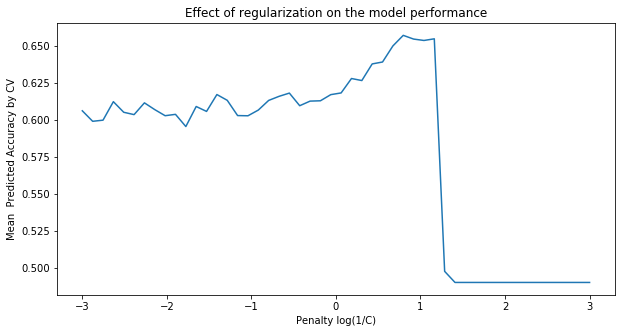

In [29]:
Cs = np.logspace(-3, 3, 50)
penalties = (1/Cs)

means =[]
stds = []
for C in Cs: 
    clf = LogisticRegression(C=C, penalty="l1")
    cv = StratifiedKFold(10,shuffle=True)
    std=[]
    mean=[]
    for i in range(20):  # I used smaller constant because 
        scores = cross_val_score(create_model(clf), X, y, cv=cv)
        std.append(scores.std())
        mean.append(scores.mean())
    means.append(np.mean(mean))
    stds.append(np.mean(std))    

fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
ax.plot(np.log10(penalties), means)
plt.title("Effect of regularization on the model performance")
plt.xlabel("Penalty log(1/C)")
plt.ylabel("Mean  Predicted Accuracy by CV")

Here we see that there is optimal value for penalty. It is approx. 10, so the optimal $C_{opt} \approx \frac{1}{10}$

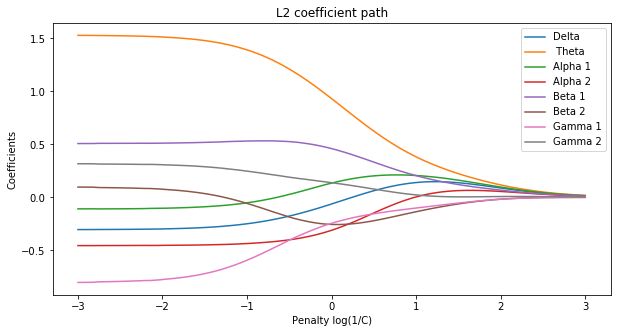

In [32]:
Cs = np.logspace(-3, 3, 100)
penalties = (1/Cs)
coefs_l1 = np.zeros((X.shape[1], len(Cs)))
for i, c in enumerate(Cs):
    scaler = StandardScaler().fit(X)
    X_transformed = scaler.transform(X)
    clf = LogisticRegression(penalty = "l2", C = c)
    clf.fit(X_transformed, y)
    coefs_l1[:, i] = clf.coef_  
plt.figure(figsize=(10,5))
plt.plot(np.log10(penalties), coefs_l1.T)
plt.title("L2 coefficient path")
plt.xlabel("Penalty log(1/C)")
plt.ylabel("Coefficients")
plt.legend(features)

Here we see that all the parameters simulteniously goes to zero with the increase of our L2 penalty coefficient. 

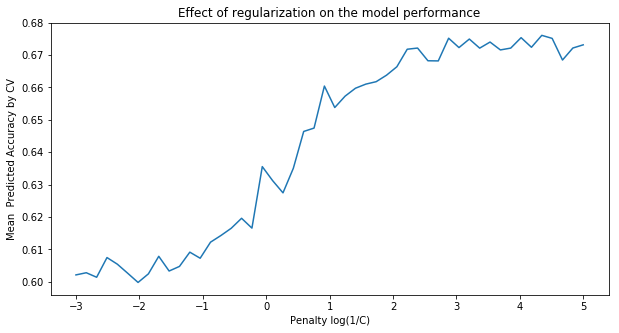

In [35]:
Cs = np.logspace(-5, 3, 50)
penalties = (1/Cs)


means =[]
stds = []
for C in Cs: 
    clf = LogisticRegression(C=C, penalty="l2")
    cv = StratifiedKFold(10,shuffle=True)
    std=[]
    mean=[]
    for i in range(20):
        scores = cross_val_score(create_model(clf), X, y, cv=cv)
        std.append(scores.std())
        mean.append(scores.mean())
    means.append(np.mean(mean))
    stds.append(np.mean(std))      
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
ax.plot(np.log10(penalties), means)
plt.title("Effect of regularization on the model performance")
plt.xlabel("Penalty log(1/C)")
plt.ylabel("Mean  Predicted Accuracy by CV")

We see that optimal penalty coefficient is bigger than 1000, so the oprimal $C_{opt} \approx 10^{-3}$

Compering this two models we can conclude that optinal L2 LR is better than L1 LR.

### Non-linear and tree-based classification models

#### Random Forest

In [36]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
calculate_score(create_model(clf), X, y)

Mean 10-fold cross-validation accuracy 0.7304, Standard deviation of the estimated accuracy 0.129


#### Fully connected NN

<a id='normalization'></a>
Look here to see the right way to fit normalization only from the train data and then apply in to the test data. 
Here I showed the ditails that are in Pipeline object. So we fit our scaler only on train data and then apply it (with alredy learned parameners) to the test data 

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(alpha=1e-5,solver='lbfgs',hidden_layer_sizes=(4,100,100,100) ,random_state=1)
scores =[]
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train_transformed = scaler.transform(X_train)
    X_test_transformed = scaler.transform(X_test)
    clf.fit(X_train_transformed,y_train)
    scores.append(clf.score(X_test_transformed, y_test))
scores=np.asarray(scores)
print("Mean 10-fold cross-validation accuracy {0:0.3}".format(scores.mean()))

Mean 10-fold cross-validation accuracy 0.58


In [38]:
calculate_score(create_model(clf), X, y)

Mean 10-fold cross-validation accuracy 0.6656, Standard deviation of the estimated accuracy 0.134


### 5. Better preprocessing makes a better classsifier

It is easy to do this preprocessing step using groupby operation. 

It is important to notice that after such transformation we restrict possible usage of our classifier. What data will we need to use our model with such preprocessing step? 

In [304]:
data
features =["Delta"," Theta", "Alpha 1", "Alpha 2", "Beta 1", "Beta 2" , "Gamma 1", "Gamma 2"]
X=data[features]
means = X.groupby("Subject ID").transform('mean')
X=X-means

In [306]:
from sklearn.svm import SVC
clf1 = LinearDiscriminantAnalysis()
clf2 = LogisticRegression(C=0.0001, penalty="l2")
clf3 = RandomForestClassifier()
clfs = [clf1,clf2,clf3]
for clf in clfs: 
    calculate_score(create_model(clf), X, y)

Mean 10-fold cross-validation accuracy 0.8788, Standard deviation of the estimated accuracy 0.0966
Mean 10-fold cross-validation accuracy 0.8783, Standard deviation of the estimated accuracy 0.0985
Mean 10-fold cross-validation accuracy 0.863, Standard deviation of the estimated accuracy 0.103
Mean 10-fold cross-validation accuracy 0.842, Standard deviation of the estimated accuracy 0.111
